In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)

In [5]:
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

In [6]:
df = df.set_index('timestamp')

In [7]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [8]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [9]:
#check anomalies in request method by looking at request method where the prob is less than .01
rm_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_count'})
rm_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_proba'})
rm_df = rm_df.merge(rm_df2)


# see those where rate < 1% 
rm_df[rm_df.rm_proba < .01]

,request_method,rm_count,rm_proba
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/sales/ HTTP/1.1,3,0.000215
11,GET /api/v1/sales/HTTP/1.1,3,0.000215
12,GET /api/v1/store HTTP/1.1,3,0.000215


22
                                  request_method  rm_count  rm_proba
12                    GET /api/v1/store HTTP/1.1         3  0.000215
13               GET /api/v1/itemsitems HTTP/1.1         3  0.000215
14                     GET /api/v1items HTTP/1.1         2  0.000143
15                    GET /api/v1/items/HTTP/1.1         1  0.000072
16              GET /api/v1/helloclass! HTTP/1.1         1  0.000072
17  GET /api/v1//api/v1/items/next_page HTTP/1.1         1  0.000072
18                          GET /api/v1 HTTP/1.1         1  0.000072
19        GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1         1  0.000072
20             GET /api/v1/items&page=0 HTTP/1.1         1  0.000072
21                  GET /api/V1/HiZach! HTTP/1.1         1  0.000072


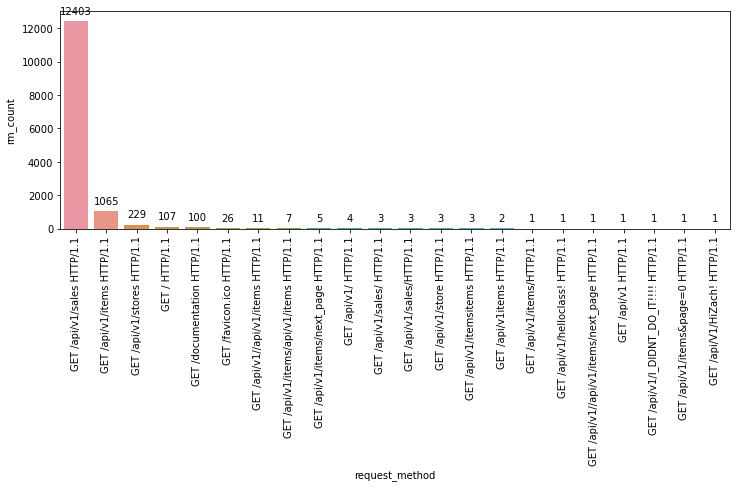

In [10]:
#Plot the request methods to visualize potential anomalies
print(len(rm_df))

print(rm_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=rm_df, x = 'request_method', y = 'rm_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

In [11]:
for col in df.columns:
    print(col)
    print(df[col].value_counts(dropna=False),'\n')


ip
97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
35.175.171.137        2
70.121.214.34         2
52.87.230.102         2
54.172.14.223         1
54.145.52.184         1
52.90.165.200         1
45.23.250.16          1
52.91.30.150          1
95.31.18.119          1
3.92.201.136          1
97.105.15.120         1
34.207.64.242         1
95.31.16.121          1
35.174.209.2          1
3.88.129.158          1
34.229.70.250         1
Name: ip, dtype: int64 

request_method
GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1            

In [12]:
ip_df = pd.DataFrame(df.ip.value_counts())
ip_df["proba"] = ip_df.ip / df.shape[0]
ip_df

,ip,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
24.26.242.9,21,0.001502
68.201.219.223,21,0.001502
35.175.171.137,2,0.000143
70.121.214.34,2,0.000143
52.87.230.102,2,0.000143
54.172.14.223,1,0.000072


In [13]:
rm_df = pd.DataFrame(df.request_method.value_counts())
rm_df["proba"] = rm_df.request_method / df.shape[0]
rm_df

,request_method,proba
GET /api/v1/sales HTTP/1.1,12403,0.887323
GET /api/v1/items HTTP/1.1,1065,0.076191
GET /api/v1/stores HTTP/1.1,229,0.016383
GET / HTTP/1.1,107,0.007655
GET /documentation HTTP/1.1,100,0.007154
GET /favicon.ico HTTP/1.1,26,0.001860
GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
GET /api/v1/items/next_page HTTP/1.1,5,0.000358
GET /api/v1/ HTTP/1.1,4,0.000286


In [14]:
status_df = pd.DataFrame(df.status.value_counts())
status_df["proba"] = status_df.status / df.shape[0]
status_df

,status,proba
200,13960,0.998712
499,16,0.001145
301,2,0.000143


In [15]:
size_df = pd.DataFrame(df['size'].value_counts())
size_df["proba"] = size_df['size'] / df.shape[0]
size_df

,size,proba
494819,705,0.050436
3561,548,0.039204
3659,291,0.020818
1328,229,0.016383
1787,219,0.015667
...,...,...
343913,1,0.000072
126,1,0.000072
360297,1,0.000072
278377,1,0.000072


In [16]:
dest_df = pd.DataFrame(df.destination.value_counts(dropna=False))
dest_df["proba"] = dest_df.destination / df.shape[0]
dest_df

,destination,proba
NaN,13953,0.998211
https://python.zach.lol/,4,0.000286
https://ds.codeup.com/8.3_Acquire/,3,0.000215
https://python.zach.lol/api/v1/,2,0.000143
https://python.zach.lol/api/v1/stores?page=1,2,0.000143
https://python.zach.lol/api/v1//api/v1/items,1,0.000072
https://python.zach.lol/api/v1/helloclass!,1,0.000072
http://localhost:8889/notebooks/timeseries_acquisition.ipynb,1,0.000072
https://python.zach.lol/api/v1//api/v1/items?page=2,1,0.000072
https://python.zach.lol/api/v1/sales?page=3,1,0.000072


In [17]:
ra_df = pd.DataFrame(df.request_agent.value_counts(dropna=False))
ra_df["proba"] = ra_df.request_agent / df.shape[0]
ra_df

,request_agent,proba
python-requests/2.21.0,12005,0.858850
python-requests/2.20.1,1911,0.136715
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",34,0.002432
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0,8,0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots),7,0.000501
Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",4,0.000286
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36",2,0.000143
Python-urllib/3.7,1,0.000072
